## AseqDIP for Multi-Coil MRI Reconstruction

This notebook implements an AseqDIP framework for multi-coil MRI reconstruction. The method leverages an untrained U-Net as an implicit image prior and optimizes the network parameters directly to fit undersampled k-space measurements.

## 1. Imports
These are the standard scientific Python and PyTorch imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from unet import UNet, FullUNet, MediumUNet, OneLayerUNet, ExtraDeepUNet, SuperDeepUNet
import torch.optim as optim
import torch.fft as fft
import torch.nn as nn
from tqdm.notebook import tqdm
#import sigpy as sp
#import sigpy.mri as mr
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
# from models import skip
#from DIP_UNET_models.skip import skip
import glob
import two_channel_dataset_DIP_github
from torch.nn import init
from torch.autograd import Variable

## 2. Load one test sample and build complex tensors
This loop takes one batch from the dataloader and converts the stored **two-channel** tensors into complex-valued k-space and sensitivity maps.

- `A_k_ref`: complex k-space with shape `(batch, coils, H, W)` (exact ordering depends on your dataset).
- `sense_maps_ref`: complex coil sensitivity maps.
- `mask_from_file`: k-space sampling mask used for data consistency.

In [2]:
for test_direct,test_target,test_smap,test_mask,test_mask_in,no_crop_smap,test_kspace in two_channel_dataset_DIP_github.test_loader:
    k_np =test_kspace
    A_k_ref = k_np[:,:, 0, :, :] + 1j * k_np[:,:, 1, :, :]
    sense_maps_ref = no_crop_smap[:,:, 0, :, :] + 1j *no_crop_smap[:,:, 1, :, :]
    mask_from_file = test_mask_in[0].float()
    print(mask_from_file.shape)

torch.Size([640, 372])


In [3]:
def init_weights(net, init_type='normal', init_gain=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


## 3. FFT helpers and SENSE forward / adjoint operations
- `fft_with_shifts` / `ifft_with_shifts` implement centered FFT/IFFT.
- `ksp_and_mps_to_gt` approximates the SENSE adjoint: combines coil images into a single image.
- `mps_and_gt_to_ksp` is the SENSE forward model: multiplies by coil maps then FFTs.

In [4]:
def fft_with_shifts(img):
    return fft.fftshift(fft.fft2(fft.ifftshift(img)))

def ifft_with_shifts(ksp):
    return fft.fftshift(fft.ifft2(fft.ifftshift(ksp)))

def ksp_and_mps_to_gt(ksp, mps):
    gt = mps.conj() * ifft_with_shifts(ksp)
    gt = torch.sum(gt, axis=0)
    return gt

def mps_and_gt_to_ksp(mps, gt):
    ksp = fft_with_shifts(mps * gt)
    return ksp

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
net =MediumUNet(n_channels=2, n_classes=2).to(device)
#net= nn.DataParallel(net).to(device)
init_weights(net, init_type='normal',init_gain=0.02)
num_epochs = 500
learning_rate = 1e-4
show_every = 500

initialize network with normal


In [7]:
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

In [8]:
criterion = nn.L1Loss()

In [9]:
ksp1 = A_k_ref[0]

In [10]:
mps1 = sense_maps_ref[0]

In [11]:
new_ref = ksp_and_mps_to_gt(mask_from_file * ksp1, mps1)

In [12]:
ref = torch.zeros(1,2,640,372)
ref[:,0,:,:] = new_ref.real
ref[:,1,:,:] = new_ref.imag

In [13]:
with torch.no_grad():
    scale_factor = torch.linalg.norm(net(ref.to(device)))/torch.linalg.norm(ksp_and_mps_to_gt(ksp1, mps1).to(device))
    target_ksp = scale_factor * ksp1.to(device)
    print('K-space scaled by: ', scale_factor)

K-space scaled by:  tensor(6360.0845, device='cuda:0')


In [14]:
gt1 = ksp_and_mps_to_gt(ksp1, mps1)

In [15]:
gt1 = torch.abs(gt1)/torch.max(torch.abs(gt1))

\begin{equation}
    \underset{\theta,z}{\min} \|MFS(\theta(z)-y)\|_1 + \|(\theta(z)-z)\|_1
\end{equation}

In [16]:
img_map = torch.sum(torch.abs(mps1), axis=0) > 0
img_map = img_map.to(device)

In [17]:
MSE = nn.MSELoss()

In [18]:
mask_from_file = torch.tensor(mask_from_file, dtype=torch.complex64).to(device)

/tmp/ipykernel_884763/1494586295.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_from_file = torch.tensor(mask_from_file, dtype=torch.complex64).to(device)


In [19]:
mps1 = mps1.to(device)
ksp1 = ksp1.to(device)

In [20]:
alpha = 0.5
avg_ksp = torch.zeros_like(ksp1)
avg_ksp = avg_ksp.to(device)

In [21]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

## 4. Main optimization loop

- Main DIP optimization loop.
- net(ref) outputs two channels (real/imag). We convert to a complex image via view_as_complex.
- Data consistency: measured k-space locations use the original ksp1; missing locations use the prediction.
- Then we update ref using the adjoint reconstruction from the consistent k-space.

  0%|          | 0/6000 [00:00<?, ?it/s]

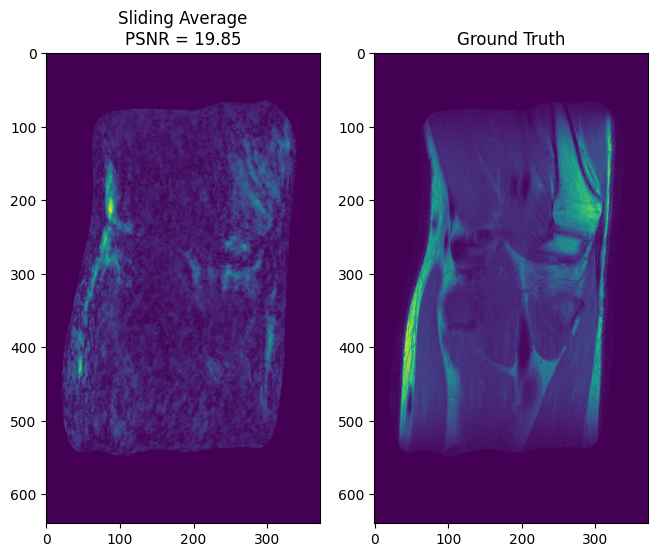

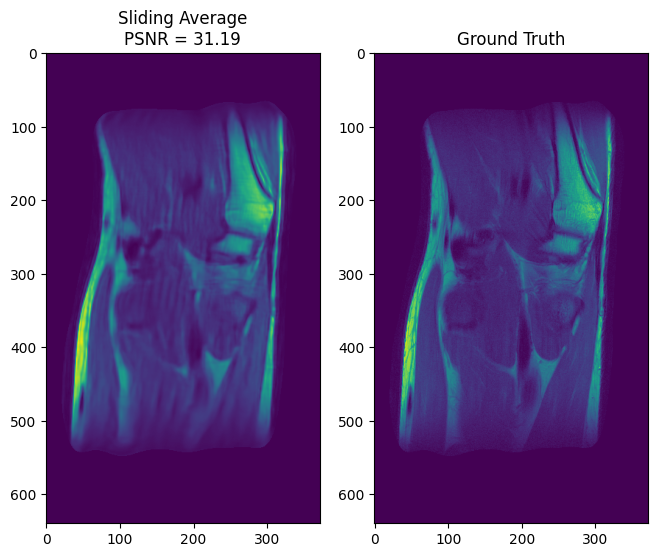

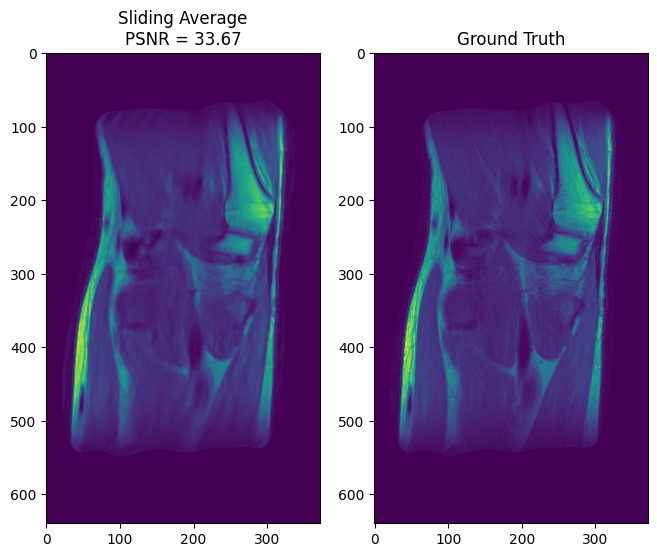

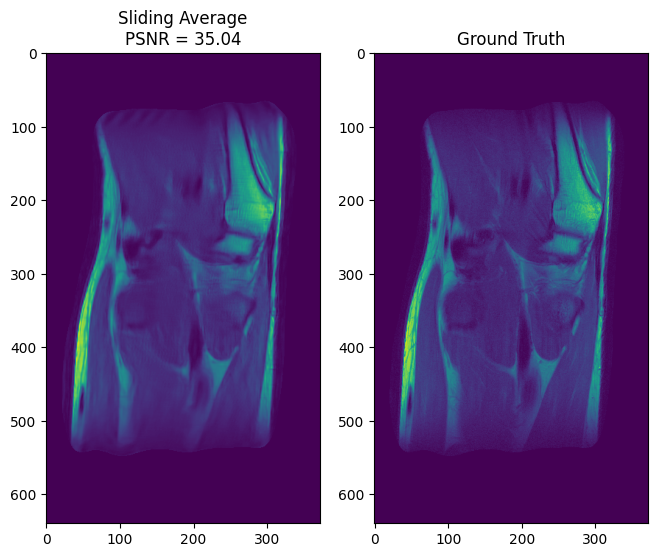

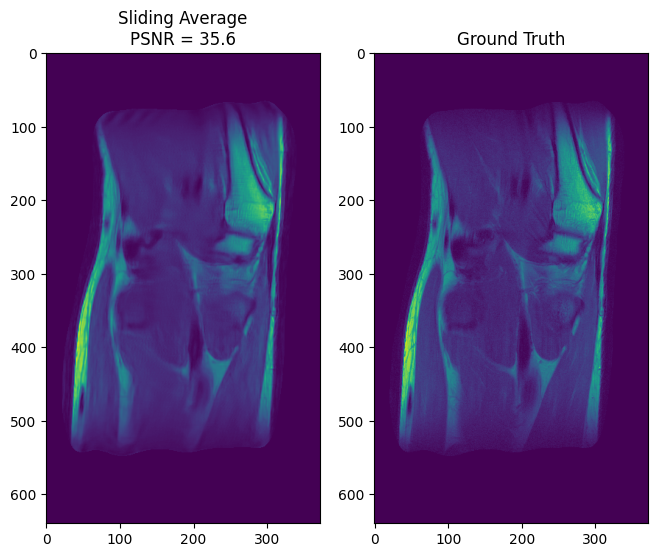

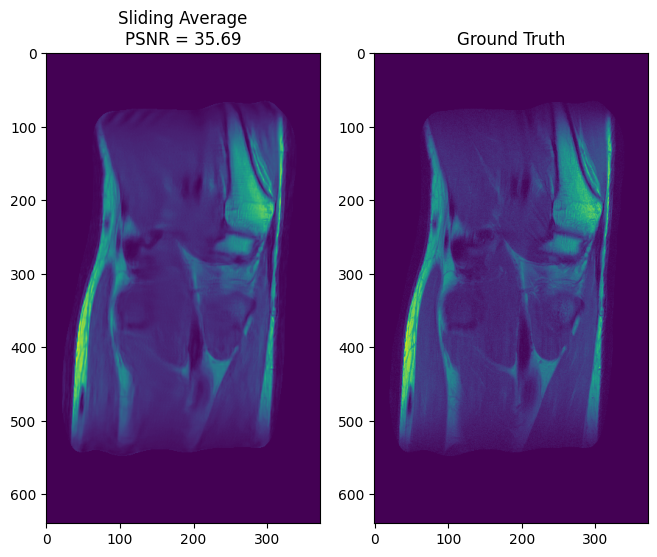

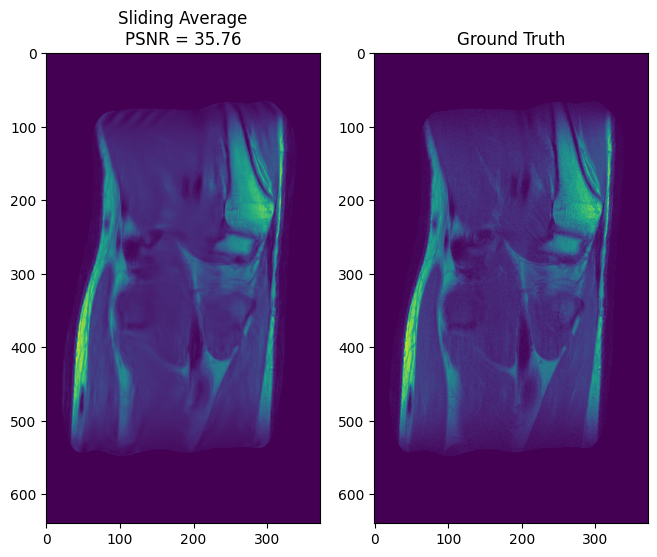

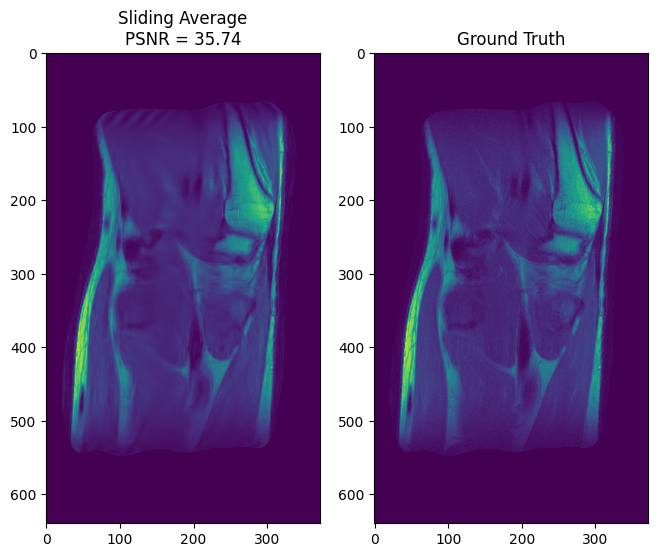

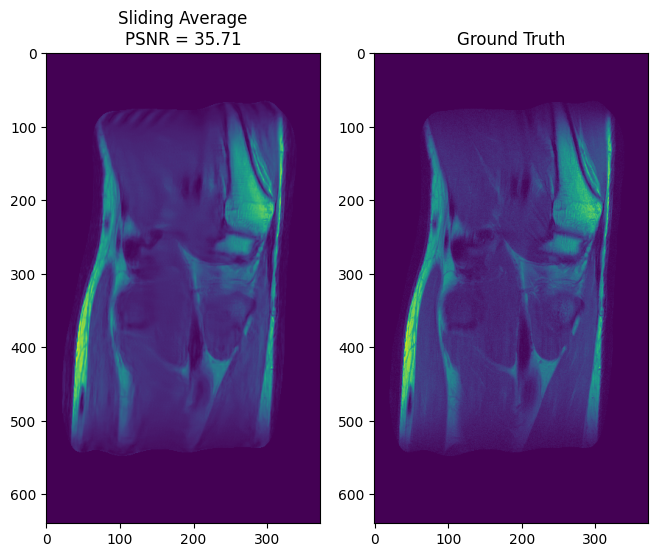

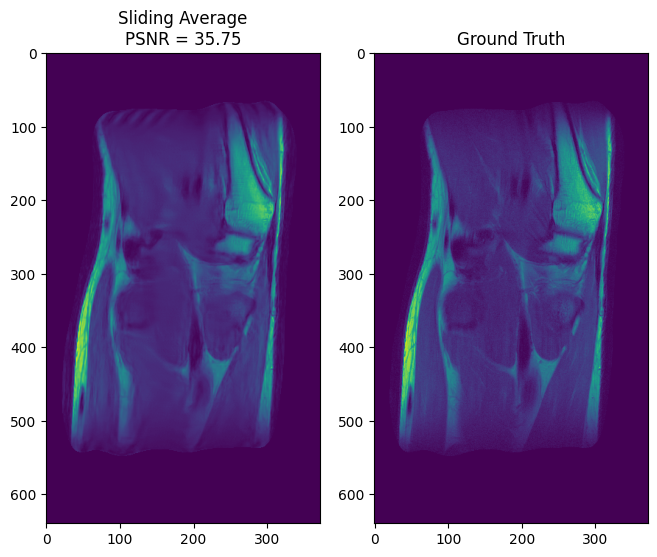

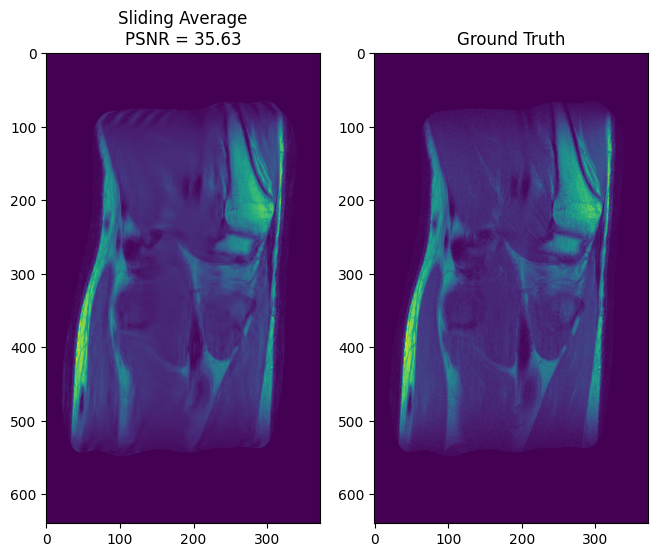

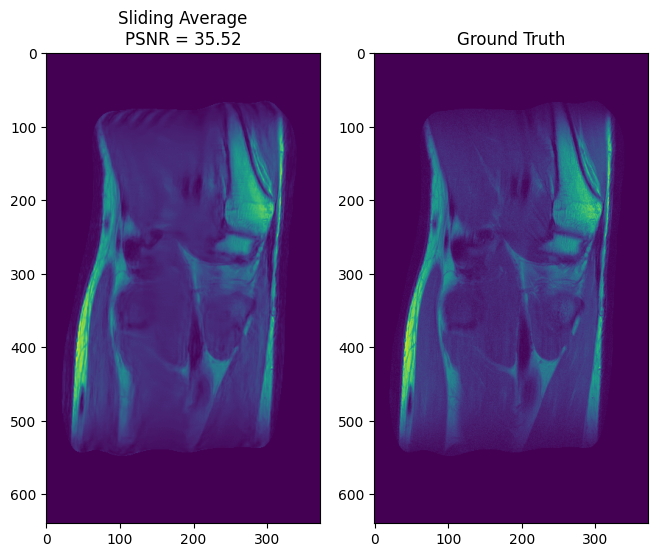

In [23]:
losses = []
psnrs = []
avg_psnrs = []
exp_weight = .99
out_avg = torch.zeros_like(torch.abs(gt1)).to(device)


for epoch in tqdm(range(6000)):
    optimizer.zero_grad()
    net_output = net(ref.to(device)).squeeze()
    net_output = torch.view_as_complex(net_output.permute(1, 2, 0).contiguous())

    pred_ksp = mps_and_gt_to_ksp(mps1.to(device), net_output)

    new_pred_ksp = (1 - mask_from_file).to(device) * pred_ksp.detach() / scale_factor + mask_from_file * ksp1

    new_ref = ksp_and_mps_to_gt(new_pred_ksp, mps1)

    ref[:, 0, :, :] = new_ref.real
    ref[:, 1, :, :] = new_ref.imag

    # Continue with your loss computation and optimization steps
    loss = torch.linalg.norm(mask_from_file * target_ksp - mask_from_file * pred_ksp.squeeze())
    + 1 * torch.linalg.norm(ref.to(device) - net_output)

    for i in range(2):
        optimizer.step()
        loss.backward(retain_graph=True)
    with torch.no_grad():
        out = img_map.to(device) * torch.abs(net_output)
        out /= torch.max(out)
        out = out.detach().squeeze()

        losses.append(loss.item())

        out_avg = out_avg * exp_weight + out * (1 - exp_weight)
        avg_psnr = compute_psnr(np.array(torch.abs(gt1)), np.array(out_avg.cpu())/float(out_avg.max().item()))
        avg_psnrs.append(avg_psnr)

        if epoch%show_every == 0:
            plt.figure(figsize=(12,12))

            plt.subplot(131)
            plt.imshow(out_avg.cpu())
            plt.title('Sliding Average\nPSNR = ' + str(round(avg_psnr, 2)))

            plt.subplot(132)
            plt.imshow(np.abs(gt1.numpy()))
            plt.title('Ground Truth')
            #plt.colorbar()

            plt.show()

In [24]:
nx = 640
ny = 372
reshape_out_avg = out_avg[ nx // 2 - 160:nx // 2 + 160, ny // 2 - 160:ny // 2 + 160].cpu()

(-0.5, 319.5, 319.5, -0.5)

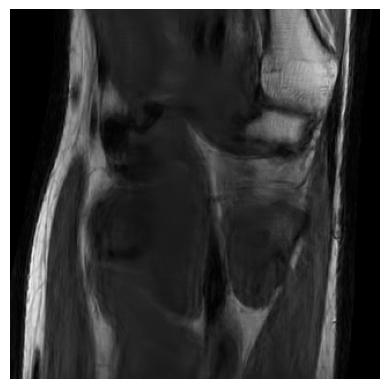

In [25]:
plt.imshow(reshape_out_avg,cmap='gray')
plt.axis('off')